In [49]:
import numpy as np
import matplotlib.pyplot as plt 
import nibabel as nib
import os 
from scipy.ndimage import gaussian_filter
from scipy import ndimage
import time 
import warnings

## Some functions 

In [50]:
# For extracting Masks 
def extract_ct_mask(file,threshold=-200, indentifier='',maskdir = None,
                    lungdir=None,save_files=True, 
                    lung_at_boundaries=False, printtolog = True):
    def touch_boundary(image):
        x = image.shape[0] - 1
        y = image.shape[1] - 1
        z = image.shape[2] - 1
        faces = []
        faces.append(np.sum(image[0,:,:]))
        faces.append(np.sum(image[x,:,:]))
        faces.append(np.sum(image[:,0,:]))
        faces.append(np.sum(image[:,y,:]))
        faces.append(np.sum(image[:,:,0]))
        faces.append(np.sum(image[:,:,z]))
        faces.remove(max(faces)) # Allow 1 side to have values
        faces.remove(max(faces)) # Allow 2 sides to have values
        if np.sum(faces) == 0:
            return False
        else:
            return True
    if type(file) == str:       
        mask_name = file.replace('.nii', '_m.nii')
        lung_name = file.split('.')[0]+indentifier+'_lung.nii.gz'
        if maskdir != None: mask_name = os.path.join(maskdir,mask_name.split('/')[-1])
        if lungdir != None: lung_name = os.path.join(lungdir,lung_name.split('/')[-1])
        if os.path.isfile(mask_name):
            if printtolog:
                print('Skipping segmentation for '+ file.split('/')[-1])
                print('segmentation exists!')
                print(mask_name)
            return 0
            
    if printtolog: 
        print('Segmenting '+ file.split('/')[-1])
    start = time.time()

    if type(file) == str:
        img = nib.load(file)
        im  = img.get_fdata()
    else:
        im = file 
    # Gaussian filter the image
    im = gaussian_filter(im, sigma=3)
    some_size = im.shape[0] * im.shape[1] * im.shape[2] / 20
    mask = im < threshold
    labeled_image,num_labels = ndimage.label(mask)
    labeled_image[labeled_image== labeled_image[0,0,0]] = 0 # Set background to 0
    label_sizes = np.bincount(labeled_image.ravel())   # count label sizes
    label_sizes[0] = 0
    count = 0
    print('Segmenting file')
    while True:
        count +=1
        lung_label = np.argmax(label_sizes)
        mask = (labeled_image == lung_label)
        if (lung_at_boundaries or not touch_boundary(mask)) : #and mask.sum() > some_size:
            break
        else:
            label_sizes[lung_label] = 0 # reset this index to 0
        if count == 10: # Avoid infinite loop
            if printtolog:
                print('Have a problem with this segmentation!')
            return -1
    # mask = ndimage.binary_fill_holes(mask)
    mask  = ndimage.binary_closing(mask).astype(np.uint8)
    print('Done')
    if save_files ==False: return mask
    #mask = ndimage.binary_fill_holes(mask,structure=np.ones((1,4,2))).astype(np.uint8)
    nii_mask = nib.Nifti1Image(mask, img.affine)
    nii_mask.to_filename(mask_name)
    # Get Lungs 
    #lung = im * mask
    #lung = nib.Nifti1Image(lung.astype(np.int16), img.affine)
    #lung.to_filename(lung_name)
    if printtolog:
        print('Segmentation for '+file.split('/')[-1] + ' finished in '+ str(int(time.time()-start)) + ' seconds')
    return 0

In [51]:
def mostafa_average(image, axis):
    im_zero = image.copy()
    im_zero[np.isnan(im_zero)] =0 
    my_ones = np.ones(im_zero.shape)
    my_ones[im_zero == 0] = 0
    r = np.nansum(im_zero, axis=axis) 
    s = np.nansum(my_ones, axis=axis) + 1e-12
    ret = np.divide(r,s).astype(np.float32)
    if np.any(np.isnan(image)): ret[ret == 0] = np.nan
    return ret#, where= (s!=0))
def get_x_slices_from_image(im, number_of_slices = 6, coronal_axis=0, transpose=False, airways=False):
    # Assumuing coronal slice at the middle 
    # Assuming 3D im 
    if coronal_axis not in [0,1,2]: 
        print('coronal_axis is wrong! Expected 0,1,2, but got',coronal_axis)
        return -1
    num_slices = im.shape[coronal_axis]
    cluster_size = int(num_slices/number_of_slices)
    image = []
    if airways: 
        x = np.nanmean(im,coronal_axis)
        mask = x !=0
        x[x==0] = np.nan
        x = filter_nan_gaussian_conserving(x, 1) * mask
        image.append(x)
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            for i in range(number_of_slices):
                s = i*cluster_size
                e = (i+1)*cluster_size
                center = s + (e-s)//2
                if coronal_axis == 0: 
                    slices = im[center,:, :]
                elif coronal_axis == 1:
                    slices = im[:,center,:]
                elif coronal_axis == 2:
                    slices = im[:,:,center]
                image.append(slices)
                # if i == number_of_slices:
                #     if coronal_axis == 0: 
                #         slices = im[s:,:, :]
                #     elif coronal_axis == 1:
                #         slices = im[:,s:,:]
                #     elif coronal_axis == 2:
                #         slices = im[:,:, s:]
                # else:
                #     if coronal_axis == 0: 
                #         slices = im[s:e,:, :]
                #     elif coronal_axis == 1:
                #         slices = im[:,s:e,:]
                #     elif coronal_axis == 2:
                #         slices = im[:,:, s:e]    
                # image.append(mostafa_average(slices,axis=coronal_axis))
                # image.append(np.nanmean(slices,axis=coronal_axis)) # .T
                
    if transpose:
        image2 = []
        for im in image: image2.append(im.T)
        image = image2
    image = np.array(image)
    return image

In [52]:
def get_cropped_CT_images(main_dir, subdir, resample_size=4, jacobian=False,use_voxels=False,raw=False):
    if jacobian:
        reg  = np.load(os.path.join(main_dir,'Analysis','Registered',subdir,'jacobian.npy'))
    elif raw:
        reg  = mask = np.load(os.path.join(main_dir,'Raw','CT',subdir,'raw.npy'))
    else:
        reg  = np.load(os.path.join(main_dir,'Analysis','Registered',subdir,'registered.npy'))
    
    mask = np.load(os.path.join(main_dir,'Raw','CT',subdir,'mask.npy'))[0]
    
    # Resample first
    if resample_size == 1:
        lung = reg.astype(np.float32)
    else:
        #  one of 0 (linear), 1 (nearest neighbor), 2 (gaussian), 3 (windowed sinc), 4 (bspline)
        lung_resampled = []
        mask_ants = ants.from_numpy(mask.astype(np.float32))
        mask = ants.resample_image(mask_ants, (resample_size,resample_size,resample_size),
                                                      use_voxels=use_voxels,interp_type=1).numpy()
        for i in range(16):
            lung_ants = ants.from_numpy(reg[i].astype(np.float32))
            lung_resampled.append(ants.resample_image(lung_ants, (resample_size,resample_size,resample_size),
                                                      use_voxels=use_voxels,interp_type=2).numpy())
        lung_resampled = np.array(lung_resampled)
        lung = lung_resampled.astype(np.float32)
        
    
    # Crop to lungs 
    lungs = []
    for i in range(lung.shape[0]):
        lungi = crop_to_mask(mask*lung[i],padding=1)
        if len(lungi) == 2: lungi = lungi[0]
        lungs.append(lungi)
    lungs = correct_cropped_images(lungs)
    
        
    # Axes: 1-saggital, 2-coronal, 3-axial
    # # Smooth each slices
    # imgs = np.zeros(lungs.shape)
    # for i in range(lungs.shape[0]):
    #     for j in range(lungs.shape[1]):
    #         imgs[i,j] = gf(lungs[i,j],1)
    # lungs = imgs
    
    # # Get Air in lungs
    # if not jacobian:
    #     lungs[lungs ==0] = np.nan
    #     lungs /= -1000
    #     lungs[lungs < 0.1] = np.nan
    
    # air = lungs.copy()
    # air[np.isnan(air)]=0
    # s = air.sum(axis=(1,2,3))
    # air_modefied = np.roll(air,-s.argmax(), axis=0)
    return lungs
def crop_to_mask(img,padding=4,im2=None):
    dim = len(img.shape)
    if im2 is None:
        # print('inside')
        im2 = img.copy()
    if dim == 3:
        filled_axis = img.any(axis=(0,1))
        img = img[:,:,filled_axis]
        im2 = im2[:,:,filled_axis]
        filled_axis = img.any(axis=(0,2))
        img = img[:,filled_axis,:]
        im2 = im2[:,filled_axis,:]
        filled_axis = img.any(axis=(1,2))
        img = img[filled_axis,:,:]
        im2 = im2[filled_axis,:,:]
    elif dim == 2:
        filled_axis = img.any(axis=0)
        img = img[:,filled_axis]
        im2 = im2[:,filled_axis]
        filled_axis = img.any(axis=1)
        img = img[filled_axis,]
        im2 = im2[filled_axis,]
    else:
        raise Exception('The image is not 2D or 3D!')
    img = np.pad(img, padding, 'constant',constant_values=(0))
    im2 = np.pad(im2, padding, 'constant',constant_values=(0))
    if (img!=im2).any(): return img,im2
    return img
def correct_cropped_images(im):
    # Correct cropped Images
    minx, miny,minz= 9999999,9999999,9999999
    for i in range(len(im)): 
        if minx > im[i].shape[0]: minx = im[i].shape[0]
        if miny > im[i].shape[1]: miny = im[i].shape[1]
        if minz > im[i].shape[2]: minz = im[i].shape[2]
    imout = []
    for i in range(len(im)): 
        imout.append(im[i][:minx,:miny,:minz])
    return np.array(imout)
def get_sorted_subfolders(adir):
    sorted_time_folders = []
    time_in_days =[]
    all_folders = os.listdir(adir)

    pre = [x for x in all_folders if 'pre' in x]
    ## Pre and 1 hour are like that 
    if len(pre): 
        sorted_time_folders.append(pre[0])
        time_in_days.append(0)
        all_folders.remove(pre[0])
    hr  =   [x for x in os.listdir(adir) if 'hr' in x]
    if len(hr):
        sorted_time_folders.append(hr[0])
        time_in_days.append(1/24)
        all_folders.remove(hr[0])
    ## All other dates will be writen in days
    nums,fnames   = [],[]
    for folder in all_folders:
        if os.path.isdir(os.path.join(adir,folder)):
            if 'day' in folder:
                nums.append(int(folder.split('__')[-1].split('.')[0].split('day')[0]))
            elif 'week' in folder:
                nums.append(int(folder.split('__')[-1].split('.')[0].split('week')[0]) * 7 )
            else:
                raise Exception("this file:"+folder + ' doesnt contain the words day or week!!')
            fnames.append(folder)

    # resort based on days
    ones_sorted = sorted(zip(nums,fnames))

    # Now append all
    for alist in ones_sorted:
        time_in_days.append(alist[0])
        sorted_time_folders.append(alist[1])
    return sorted_time_folders, time_in_days

In [53]:
def get_maps(main_dir, num_slices = 6, vmin=0.5, vmax=1.2, key='', save_name='',
            return_slices = False):
    if key =='':
        print('You must select key: FV, TV, FRC, J')
        return 0
    analysis_dir = os.path.join(main_dir, 'Analysis', 'Registered')
    raw_dir      = os.path.join(main_dir, 'Raw', 'CT')
    subfolder = os.listdir(analysis_dir)[0]
    registered_file = os.path.join(analysis_dir, subfolder, 'registered.npy')
    Jacobian_file = os.path.join(analysis_dir, subfolder, 'jacobian.npy')
    
    reg = np.load(registered_file)
    J   = np.load(Jacobian_file)[1]
    
    # mask_fname = [x for x in os.listdir(os.path.join(raw_dir,subfolder)) if 'R0_m.nii' in x][0]
    mask_fname = [x for x in os.listdir(os.path.join(raw_dir,subfolder)) if 'mask.nii' in x][0]
    mask_fname = os.path.join(raw_dir,subfolder, mask_fname)
    mask  = nib.load(mask_fname).get_fdata()
    # ee  = nib.load(ee_fname).get_fdata()
    ee = reg[1]
    ei = reg[0]

    ee_masked = crop_to_mask(ee * mask,padding=4,im2=None)
    ei_masked = crop_to_mask(ei * mask,padding=4,im2=None)
    J_masked  = crop_to_mask(J  * mask,padding=4,im2=None)
    mask_masked  = crop_to_mask(mask,padding=4,im2=None)

    ee_slices = get_x_slices_from_image(ee_masked, number_of_slices = num_slices, 
                             coronal_axis=1, transpose=False, airways=False)

    ei_slices = get_x_slices_from_image(ei_masked, number_of_slices = num_slices, 
                             coronal_axis=1, transpose=False, airways=False)
    
    J_slices  = get_x_slices_from_image(J_masked, number_of_slices = num_slices, 
                             coronal_axis=1, transpose=False, airways=False)

    mask_slices  = get_x_slices_from_image(mask_masked, number_of_slices = num_slices, 
                             coronal_axis=1, transpose=False, airways=False)

    FV_slices =  1- np.divide(ee_slices*J_slices, ei_slices, where = ei_slices!=0)
    # return ee_slices, J_slices, ei_slices
    # return J
    if key == 'J':
        im = (1-J_slices) * mask_slices
    elif key == 'FV': 
        im = FV_slices * mask_slices
    elif key == 'FRC':
        im = ee_slices/-1000
        im[im > 1] = 1
        im[im < 0] = np.nan
    elif key == 'TV':
        ee_volume = ee_slices/-1000
        ei_volume = ei_slices/-1000
        TV = (ei_volume - ee_volume) * mask_slices     
        im = TV
        
    im[im == 0] = np.nan
    # return im 
    if return_slices:
        return im
    if save_name != '': 
        s = 1
        fig, axes = plt.subplots(1, num_slices, figsize=(16*s, 4*s), dpi=400, facecolor='k')
        cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust the position as needed
        for i, ax in enumerate(axes): 
            img = ax.imshow(im[i].T, origin='lower', cmap='jet', vmin=vmin, vmax=vmax) 
            ax.axis('off')
        # Add a single colorbar for the whole figure
        cbar = fig.colorbar(img, cax=cbar_ax)
        cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])
        cbar.ax.yaxis.set_tick_params(color='white')  # Change tick color
        plt.setp(plt.getp(cbar.ax, 'yticklabels'), color='white', fontsize=20)  # Change tick label color
        plt.savefig(save_name, bbox_inches='tight', dpi=400) 
        plt.close()
    print(save_name, np.nanmean(im))
    return 0

In [54]:
def save_image(im, imname, vmin, vmax, cmap='jet', title = ''):
    s = 2
    num_slices = len(im)
    num_cols = 6
    num_rows = int(np.ceil(num_slices / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*s, num_rows*s), dpi=400, facecolor='k')
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust the position as needed
    axes = axes.flatten()
    for i in range(num_slices): 
        img = axes[i].imshow(im[i].T, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax) 
        axes[i].axis('off')
    for j in range(num_slices, len(axes)):
        axes[j].axis('off')
    # Add a single colorbar for the whole figure
    cbar = fig.colorbar(img, cax=cbar_ax)
    cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])
    cbar.ax.yaxis.set_tick_params(color='white')  # Change tick color
    plt.setp(plt.getp(cbar.ax, 'yticklabels'), color='white', fontsize=20)  # Change tick label color
    fig.suptitle(title, color='white', fontsize=24, weight='bold')
    plt.savefig(imname, bbox_inches='tight', dpi=400) 
    plt.close()

## Run from here

In [55]:
# Add Path to your .nii image
image_nifti_file_path = '/Users/mostafaismail/Documents/Carly/example_CT.nii'

In [56]:
extract_ct_mask(image_nifti_file_path, printtolog=True)

Segmenting example_CT.nii
Segmenting file
Done
Segmentation for example_CT.nii finished in 7 seconds


0

In [57]:
mask_nifti_file_path = image_nifti_file_path.replace('.nii', '_m.nii')

In [58]:
# Loading the images
image = nib.load(image_nifti_file_path).get_fdata()
mask  = nib.load(mask_nifti_file_path).get_fdata()

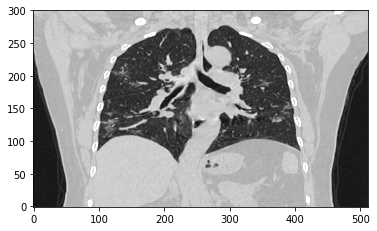

In [59]:
# The image looks like this ... 
# Note that you can change the slice number (300) to other slices.. 
plt.imshow(image[:,300].T, origin='lower', cmap='gray', vmin=-1150, vmax=350)

In [60]:
masked_image = image*mask
cropped_masked_image = crop_to_mask(masked_image,padding=4,im2=None)

In [61]:
cropped_masked_image.shape

(330, 240, 258)

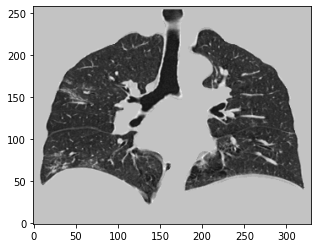

In [62]:
# The masked image looks like this ... 
# Note that you can change the slice number (300) to other slices.. 
plt.imshow(cropped_masked_image[:,100].T, origin='lower', cmap='gray', vmin=-1150, vmax=350)

In [63]:
# Calculate air contenct 
air_content = cropped_masked_image / -1000 
air_content[air_content ==0] = np.nan

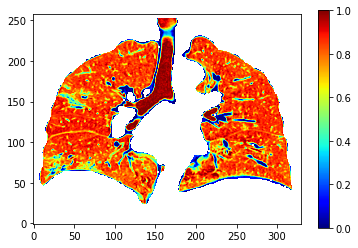

In [64]:
# The air content image looks like this ... 
# Note that you can change the slice number (300) to other slices.. 
plt.imshow(air_content[:,100].T, origin='lower', cmap='jet', vmin=0, vmax=1)
plt.colorbar()

In [65]:
num_slices = 6
im = get_x_slices_from_image(air_content, number_of_slices = num_slices, 
                             coronal_axis=1, transpose=False, airways=False)

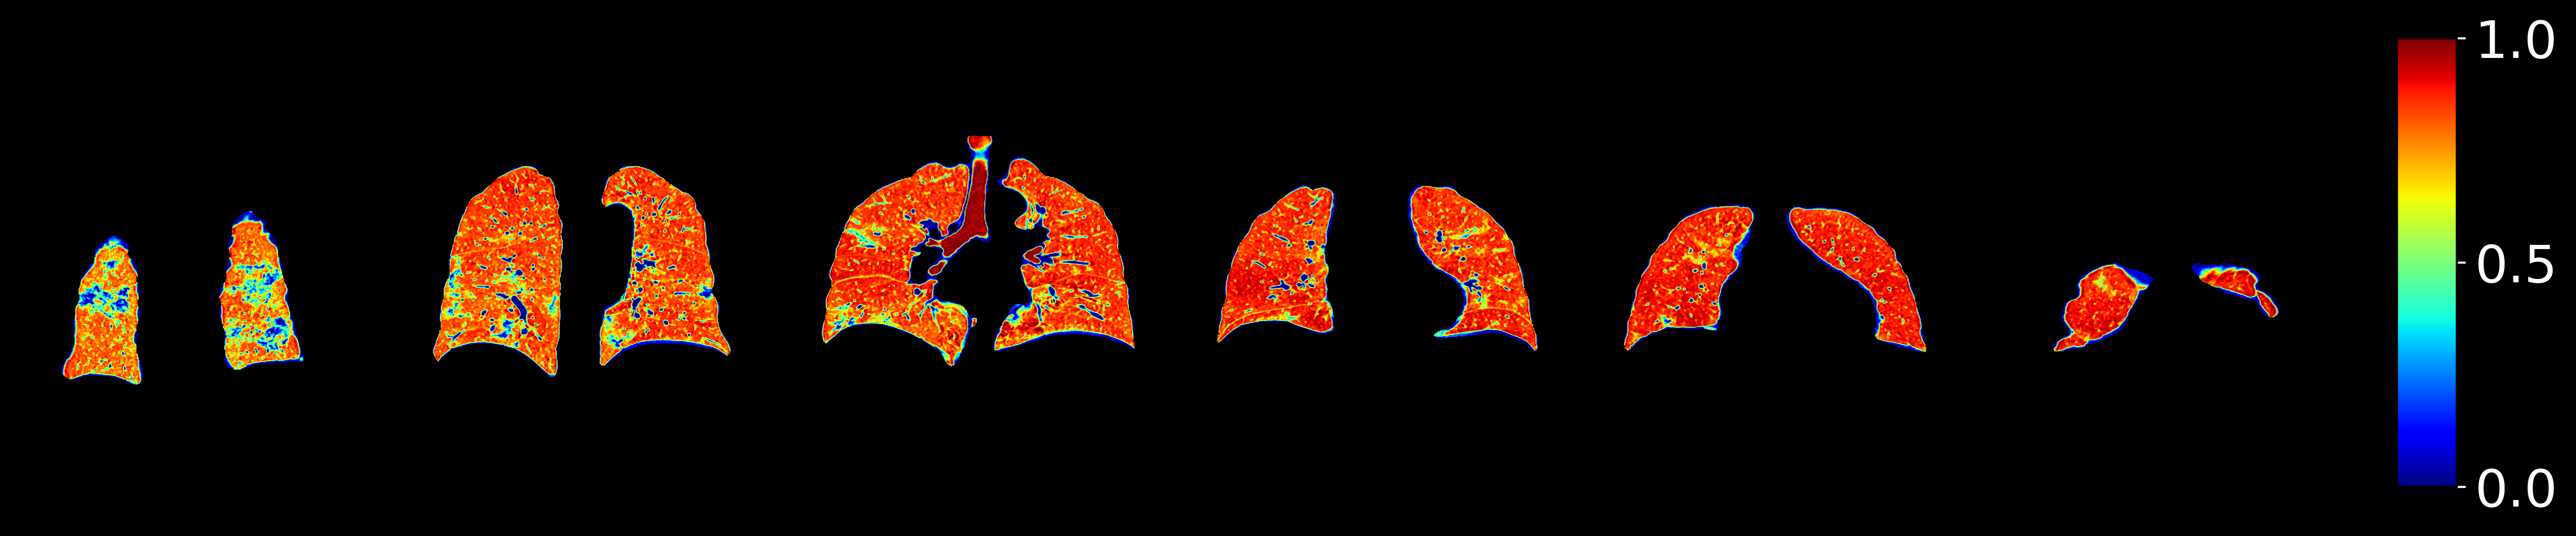

In [66]:
s=1
vmin, vmax = 0,1
fig, axes = plt.subplots(1, num_slices, figsize=(16*s, 4*s), dpi=400, facecolor='k')
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust the position as needed
for i, ax in enumerate(axes): 
    img = ax.imshow(im[i].T, origin='lower', cmap='jet', vmin=vmin, vmax=vmax) 
    ax.axis('off')
# Add a single colorbar for the whole figure
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])
cbar.ax.yaxis.set_tick_params(color='white')  # Change tick color
plt.setp(plt.getp(cbar.ax, 'yticklabels'), color='white', fontsize=20)  #\
parent_dir = os.path.dirname(image_nifti_file_path)
plt.savefig(os.path.join(parent_dir, 'Air_contect.png'),
                         bbox_inches='tight', dpi=400)